In [12]:
import numpy as np
import nashpy as nash
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as opti

In [91]:
class tp_game: #two player game
    
    def __init__(self,efficiency_list, impact_list, grating, tax):
        self.effs = np.array(efficiency_list)
        self.imps = np.array(impact_list)
        self.tax = tax #must be a function tax(action,efficiency,impact)
        self.action_space = np.linspace(0,1,grating,endpoint = True)    
        self.full_action_space = np.moveaxis(np.swapaxes(np.array(np.meshgrid(self.action_space,self.action_space)),1,2),0,-1)
            #full_action_space[:,i,j,k,...] gives an action profile where player 1 takes ith action, player 2 the jth action, player 3 the kth action etc.
        
    def uti_matrix_2(self): #same output as uti_matrix but scalabe
        new_matrix = np.empty_like(self.full_action_space)
               
        ais = range(np.shape(self.full_action_space)[0]) #action indices
        index_space = np.moveaxis(np.array(np.meshgrid(ais,ais)),0,-1)
        
        for i in index_space:
            for j in i:
                new_matrix[j[0],j[1]] = np.array([self.uti_all(np.array([self.action_space[k] for k in j]))])
        return new_matrix
            
    
    def uti_all(self,action_profile): #array of utility for all players at given action profile 
        return np.array([self.uti_single(i,action_profile) for i in range(2)])
            
    def uti_single(self,i,action_profile): #utility for player i at given action profile
        impact_profile = self.imps * action_profile
        return self.effs[i]*action_profile[i]/(1+sum(impact_profile)**2) + self.tax(action_profile[i],self.effs[i],self.imps[i])
    
        
    def uti_matrix(self):
        temp = []
        for i in self.action_space:
            temp2 = []
            for j in self.action_space:
                temp2.append(self.uti_all(np.array([i,j])))
            temp.append(temp2)
        return np.array(temp)
    
    def create_Nash_game(self):
        um = self.uti_matrix()
        return nash.Game(um[:,:,0],um[:,:,1])
            
    def NE(self):
        game = self.create_Nash_game()
        return list(game.support_enumeration())
        

In [1]:
class n_player_steps(): #n player game with heaviside as tax
    
    def __init__(self, eff_list, imp_list, grating, subtax):
        self.n = len(eff_list) #amount of players
        self.eff_list = np.array(eff_list) #list of efficiency values of players
        self.imp_list = np.array(imp_list) #list of impact values of players
        self.action_space = np.linspace(0,1,grating,endpoint = True)    
        self.subtax = subtax #must be a function subtax(efficiency, impact)
        
    def uti_null_single(self,i,action):
        return self.eff_list[i]*action/(1+(self.imp_list[i]*action)**2)-2*np.heaviside(action-self.subtax(self.eff_list[i],self.imp_list[i]),0)
        
        
    def best_response(self,i):
        res = np.array([self.uti_null_single(i,a) for a in self.action_space]) #np.array([self.uti_single(i,action) for action in self.action_space()])
        return self.action_space[np.argmax(res)]
    
    def nash_eqs(self): #returns array of actions that are a NE of the game
        return np.array([self.best_response(i) for i in range(self.n)])
    
    def total_usage(self):
        return np.sum(self.imp_list * self.nash_eqs())/np.sum(self.imp_list)
    
    def total_outcome(self):
        return np.sum(self.nash_utis())
    
    def standard_dev(self):
        return np.std(self.nash_utis())
        
    
    def nash_utis(self): #returns array of utilities at the NE
        actions = self.nash_eqs()
        usage = actions * self.imp_list
        taxes = [2*np.heaviside(actions[i]-self.subtax(self.eff_list[i],self.imp_list[i]),0) for i in range(self.n)]
        
        return self.eff_list*actions/(1+np.sum(usage)**2) - taxes
    

In [52]:
def p_notax(alpha):
    def newtax(e,i): return 1
    return newtax

def p_consttax(alpha):
    def newtax(e,i): return alpha
    return newtax

def p_simpletax(alpha):
    def newtax(e,i): return alpha/i
    return newtax

def p_simpletax2(alpha):
    def newtax(e,i): return e/i*alpha
    return newtax

def p_simpletax3(alpha):
    def newtax(e,i): return alpha*e/(i**2)
    return newtax

def p_generaltax(alpha,beta,gamma,delta):
    def newtax(e,i): return alpha + beta/i**2 + gamma*e/i  + delta*e**2/i**2
    return newtax



In [76]:
def minf(alpha, pop):
    tax = p_simpletax3(alpha)
    newgame = n_player_steps(pop[0],pop[1],100,tax)
    return newgame.standard_dev()/newgame.total_outcome()


def maxf1(alpha,pop):
    #print(alpha)
    tax = p_consttax(alpha)
    newgame = n_player_steps(pop[0],pop[1],100,tax)
    return -newgame.total_outcome()

    

In [77]:
for i in np.linspace(0,1,10):
    print(maxf1(i,pop))

-0.0
-0.19409861778257037
-0.3595330739299611
-0.455925739368209
-0.4950863522707449
-0.4972375690607735
-0.48200441931013815
-0.45731651724661904
-0.42982259151134067
-0.4


In [95]:
pop = [[1,1],[1,0.5]]
opti.differential_evolution(maxf1, args = (pop,), bounds = [(0.4,0.6)])


 message: Optimization terminated successfully.
 success: True
     fun: -1.324996810003828
       x: [ 5.969e-01]
     nit: 2
    nfev: 47

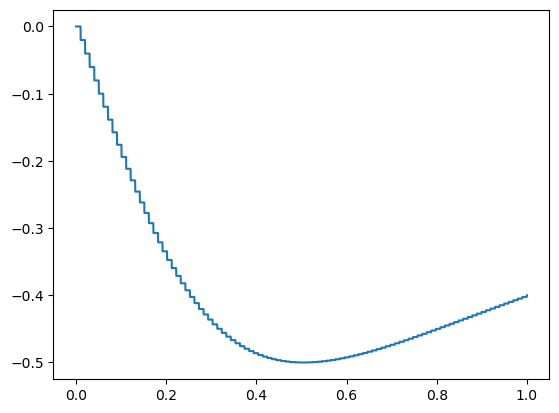

In [92]:
bereich = np.linspace(0,1,3000)
plt.plot(bereich,[maxf1(i,pop)for i in bereich])

In [49]:
#2 player test
pop = [[1,1],[1,1]]


In [30]:
minf(1,pop)

0.0

In [93]:
n = 9

def nosubtax(a,b):
    return 1

def consttax(e,i):
    return 0.5

def consttax2(e,i):
    return 1/n

def simpletax(e,i):
    return (1/n) / i

def simpletax2(e,i):
    return (1/n) *e /i

def simpletax3(e,i):
    return (1/n) * e/(i*i)

taxes = [nosubtax,consttax2,simpletax,simpletax2]#,simpletax3]
names = ['No Tax', 'Constant Rate', 'Rate by 1/Impact', 'Rate by Eff/Imp']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


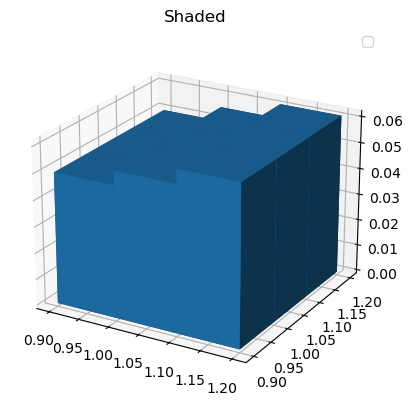

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


effs, imps = np.meshgrid(np.linspace(0.9,1.1,3),np.linspace(0.9,1.1,3))
effs, imps = effs.flatten(), imps.flatten()
test = n_player_steps(effs,imps,30,taxes[1])

top = test.nash_utis()
bottom = np.zeros_like(top)
width = depth = 0.1

ax.bar3d(effs, imps, bottom, width, depth, top, shade=True)
ax.set_title('Shaded')

ax.view_init(elev=22.5, azim=300)
plt.legend()
plt.show()
# Scatter plot


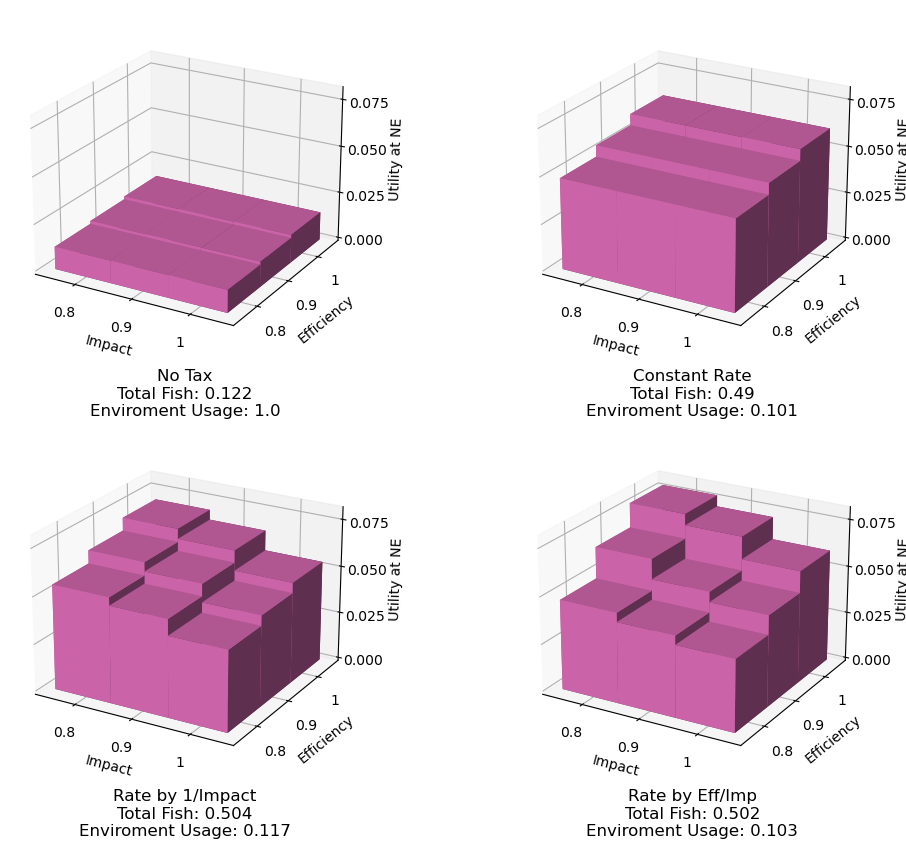

In [95]:


effs, imps = np.meshgrid(np.linspace(0.8,1,3),np.linspace(0.8,1,3))
effs, imps = effs.flatten(), imps.flatten()


# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})#, constrained_layout=True)

# Loop through each subplot and plot the 3D bar diagram
for i in range(2):
    for j in range(2):
        k = 2*i+j
        ax = axes[i, j]
        newgame = n_player_steps(effs,imps,100,taxes[k])
        
        top = newgame.nash_utis()
        bottom = np.zeros_like(top)
        width = depth = 0.1

        ax.bar3d(imps, effs, bottom, width, depth, top, shade=True, color = '#e570bd')
        
        # Set labels and title for each subplot
        ax.set_ylabel('Efficiency')
        ax.set_xlabel('Impact')
        ax.set_zlabel('Utility at NE')
        ax.set_title(names[k] + "\n" + "Total Fish: " + str(np.around(newgame.total_outcome(),3)) + "\n"
                     + "Enviroment Usage: " + str(np.around(newgame.total_usage(),3)), y = -0.2)
        ax.set_zlim([0,0.08])
        ax.set_xticks([0.85,0.95,1.05],['0.8','0.9','1'])
        ax.set_yticks([0.85,0.95,1.05],['0.8','0.9','1'])
        ax.set_zticks([0,0.025,0.05,0.075])
        
        
        ax.view_init(elev=22.5, azim=-60)


# Show the plot
#plt.subplots_adjust(left=0.05, right=1.5, top=0.95, bottom=0.05)

plt.savefig('test.png',dpi=600)
plt.show()



In [15]:
#Population + Taxes for Population test:


n = 20

def totfish(tax,pop):
    newgame = n_player_steps(pop[0],pop[1],100,tax)
    return newgame.total_outcome()
def totuse(tax,pop):
    newgame = n_player_steps(pop[0],pop[1],100,tax)
    return newgame.total_usage()
def stddv(tax,pop):
    newgame = n_player_steps(pop[0],pop[1],100,tax)
    return 1

n = 20

def nosubtax(a,b):
    return 1

def consttax(e,i):
    return 0.5

def consttax2(e,i):
    return 1/n

def simpletax(e,i):
    return (1/n) / i

def simpletax2(e,i):
    return (1/n) *e /i

def simpletax3(e,i):
    return (1/n) * e/(i*i)

taxes = [nosubtax,consttax2,simpletax,simpletax2]#,simpletax3]
names = ['No Tax', 'Constant Rate', 'Rate by 1/Impact', 'Rate by Eff/Imp']


pop1 =[[0.5+0.5*np.random.random() for i in range(n)],[0.5+0.5*np.random.random() for i in range(n)],'All Random (AR)']

xrand = [0.5+0.5*np.random.random() for i in range(n)]
yrand = [np.random.random() for i in range(n)]
pop2 =[xrand , [np.min([0.9*xrand[i] + 0.2 * yrand[i],1]) for i in range(n)],'Correlation (CO)']

xrand = [0.5+0.5*np.random.random() for i in range(n)]
yrand = [np.random.random() for i in range(n)]
pop2b =[xrand , [np.min([0.9*(1.5-xrand[i]) + 0.2 * yrand[i],1]) for i in range(n)],'Anticorrelation (AC)']

xrand = np.random.normal(0.75,0.07,n)
yrand = np.random.normal(0.75,0.07,n)
pop3 =[xrand,yrand,'Cluster 1']


xrand = np.append(np.random.normal(0.6,0.04,int(n/2)),np.random.normal(0.9,0.04,int(n/2)))
yrand = np.append(np.random.normal(0.6,0.04,int(n/2)),np.random.normal(0.9,0.04,int(n/2)))
pop4 =[xrand,yrand,'Cluster 2']

xrand = np.append(np.random.normal(0.9,0.04,int(n/2)),np.random.normal(0.6,0.04,int(n/2)))
yrand = np.append(np.random.normal(0.6,0.04,int(n/2)),np.random.normal(0.9,0.04,int(n/2)))
pop5 =[xrand,yrand,'Cluster 3']

pops = [pop1, pop2,pop2b,pop3,pop4,pop5]



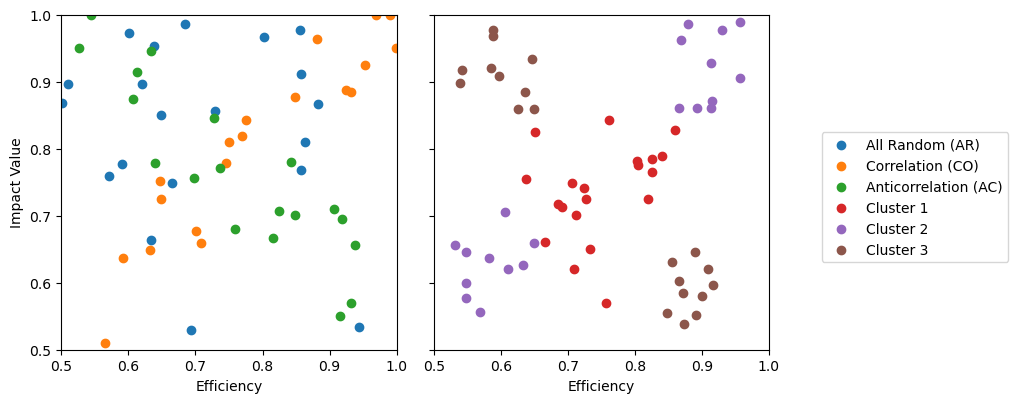

In [99]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4),sharey=True,sharex=True)

# Scatter plot in the first subplot
plotlist= [0 for i in range(6)]
namelist = [0 for i in range(6)]
i= 0
for p in pops[0:3]:
    plotlist[i] = axs[0].scatter(p[0],p[1], label =p[2])
    namelist[i] = p[2]
    i = i+1
    
axs[0].set_ylabel('Impact Value')
axs[0].set_xlabel('Efficiency')
#axs[0].legend()
axs[0].set_xlim([0.5,1])
axs[0].set_ylim([0.5,1])



for p in pops[3:6]:
    plotlist[i] = axs[1].scatter(p[0],p[1], label =p[2],color = colors[i])
    namelist[i] = p[2]
    i = i+1
    
#axs[1].set_ylabel('Impact Value')
axs[1].set_xlabel('Efficiency')
##axs[1].legend()


axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')

legend = fig.legend(plotlist,namelist,loc='center', bbox_to_anchor=(1.15, 0.5), ncol=1)


# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot



plt.savefig('population.png',dpi=600,bbox_inches ='tight')
plt.show()



C:\Users\erik-\AppData\Local\Temp\ipykernel_16836\3293269952.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(plotlist, labels=names, loc='center', bbox_to_anchor=(1.1, 0.5), ncol=1)


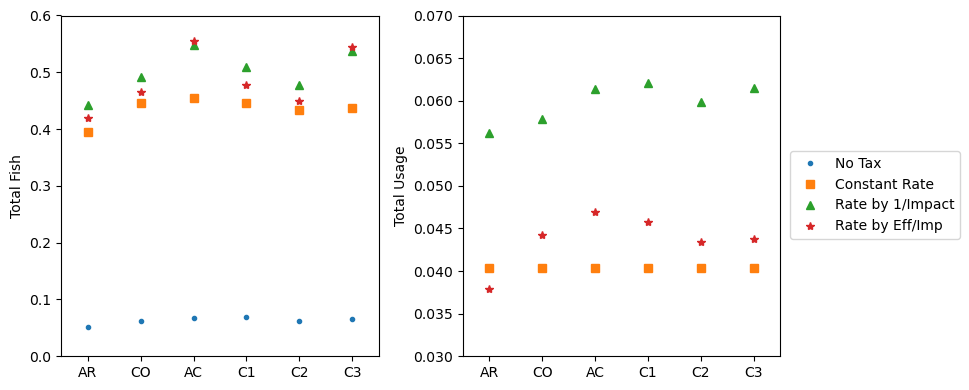

In [98]:
# Assuming pops and taxes are defined earlier in your code

xs = range(len(pops))
markers = ['.', 's', '^', '*']
plotlist = [1, 2, 3, 4]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

for i in range(len(taxes)):
    plotlist[i], = axs[0].plot(xs, [totfish(taxes[i], p) for p in pops], linewidth=0, marker=markers[i], label=names[i])

for i in range(1, len(taxes)):
    axs[1].plot(xs, [totuse(taxes[i], p) for p in pops], linewidth=0, marker=markers[i], label=names[i], color=colors[i])

axs[0].set_xticks(list(range(6)))
axs[0].set_xticklabels(['AR', 'CO', 'AC', 'C1', 'C2', 'C3'])
axs[0].set_xlim([-0.5, 5.5])
axs[0].set_ylim([0, 0.6])
axs[1].set_ylim([0.03, 0.07])

axs[0].set_ylabel('Total Fish')
axs[1].set_ylabel('Total Usage')

# Uncomment the following lines if you want to equalize the aspect ratio
# axs[0].set_aspect('equal', adjustable='box')
# axs[1].set_aspect('equal', adjustable='box')

# Display the legend
fig.legend(plotlist, labels=names, loc='center', bbox_to_anchor=(1.1, 0.5), ncol=1)

# Adjust layout to prevent clipping of the legend
plt.tight_layout()

# Show the plot
plt.savefig('Poptest.svg',bbox_inches ='tight')
plt.show()


In [83]:
#data generation for distributions

#Population + Taxes for Population test:


n = 20
m = 50

def totfish(tax,pop):
    newgame = n_player_steps(pop[0],pop[1],100,tax)
    return newgame.total_outcome()
def totuse(tax,pop):
    newgame = n_player_steps(pop[0],pop[1],100,tax)
    return newgame.total_usage()

n = 20

def nosubtax(a,b):
    return 1

def consttax(e,i):
    return 0.5

def consttax2(e,i):
    return 1/n

def simpletax(e,i):
    return (1/n) / i

def simpletax2(e,i):
    return (1/n) *e /i

def simpletax3(e,i):
    return (1/n) * e/(i*i)

taxes = [nosubtax,consttax2,simpletax,simpletax2]#,simpletax3]
names = ['No Tax', 'Constant Rate', 'Rate by 1/Impact', 'Rate by Eff/Imp']

res1 = []
res2 = []

for j in range(m):
    pop1 =[[0.5+0.5*np.random.random() for i in range(n)],[0.5+0.5*np.random.random() for i in range(n)],'All Random (AR)']

    xrand = [0.5+0.5*np.random.random() for i in range(n)]
    yrand = [np.random.random() for i in range(n)]
    pop2 =[xrand , [np.min([0.9*xrand[i] + 0.2 * yrand[i],1]) for i in range(n)],'Correlation (CO)']

    xrand = [0.5+0.5*np.random.random() for i in range(n)]
    yrand = [np.random.random() for i in range(n)]
    pop2b =[xrand , [np.min([0.9*(1.5-xrand[i]) + 0.2 * yrand[i],1]) for i in range(n)],'Anticorrelation (AC)']

    xrand = np.random.normal(0.75,0.07,n)
    yrand = np.random.normal(0.75,0.07,n)
    pop3 =[xrand,yrand,'Cluster 1']


    xrand = np.append(np.random.normal(0.6,0.04,int(n/2)),np.random.normal(0.9,0.04,int(n/2)))
    yrand = np.append(np.random.normal(0.6,0.04,int(n/2)),np.random.normal(0.9,0.04,int(n/2)))
    pop4 =[xrand,yrand,'Cluster 2']

    xrand = np.append(np.random.normal(0.9,0.04,int(n/2)),np.random.normal(0.6,0.04,int(n/2)))
    yrand = np.append(np.random.normal(0.6,0.04,int(n/2)),np.random.normal(0.9,0.04,int(n/2)))
    pop5 =[xrand,yrand,'Cluster 3']

    pops = [pop1, pop2,pop2b,pop3,pop4,pop5]
    
    res1.append([[totfish(t,p) for t in taxes] for p in pops])
    res2.append([[totuse(t,p) for t in taxes] for p in pops])
    
res1 = np.array(res1)
res2 = np.array(res2)

np.shape(res1)
    
    



(50, 6, 4)

In [ ]:
avs1 = np.average(res1,axis=0)
sig1 = np.std(res1,axis=0)
avs2 = np.average(res2,axis=0)
sig2 = np.std(res2,axis=0)

C:\Users\erik-\AppData\Local\Temp\ipykernel_16836\914211997.py:31: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(plotlist, labels=names, loc='center', bbox_to_anchor=(1.1, 0.5), ncol=1)


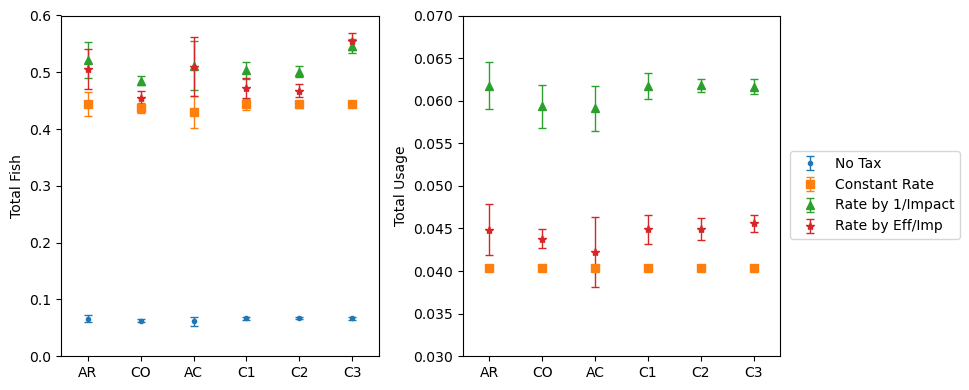

In [87]:
xs = range(len(pops))
markers = ['.', 's', '^', '*']
plotlist = [1, 2, 3, 4]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

for i in range(len(taxes)):
    axs[0].errorbar(range(6),avs1[:,i],sig1[:,i],marker=markers[i],linewidth=0,elinewidth=1,capsize=3)
    axs[1].errorbar(range(6),avs2[:,i],sig2[:,i],marker=markers[i],linewidth=0,elinewidth=1,capsize=3)

#for i in range(len(taxes)):
#    plotlist[i], = axs[0].errorbar(xs, avs1[:,i], sig1[:,i])#, linewidth=0, marker=markers[i], label=names[i])

#for i in range(1, len(taxes)):
#    axs[1].plot(xs, [totuse(taxes[i], p) for p in pops], linewidth=0, marker=markers[i], label=names[i], color=colors[i])

axs[0].set_xticks(list(range(6)))
axs[0].set_xticklabels(['AR', 'CO', 'AC', 'C1', 'C2', 'C3'])
axs[0].set_xlim([-0.5, 5.5])
axs[0].set_ylim([0, 0.6])
axs[1].set_ylim([0.03, 0.07])

axs[0].set_ylabel('Total Fish')
axs[1].set_ylabel('Total Usage')


fig.legend(plotlist, labels=names, loc='center', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.tight_layout()
plt.savefig('Poptest.png',bbox_inches ='tight', dpi=600)
plt.show()


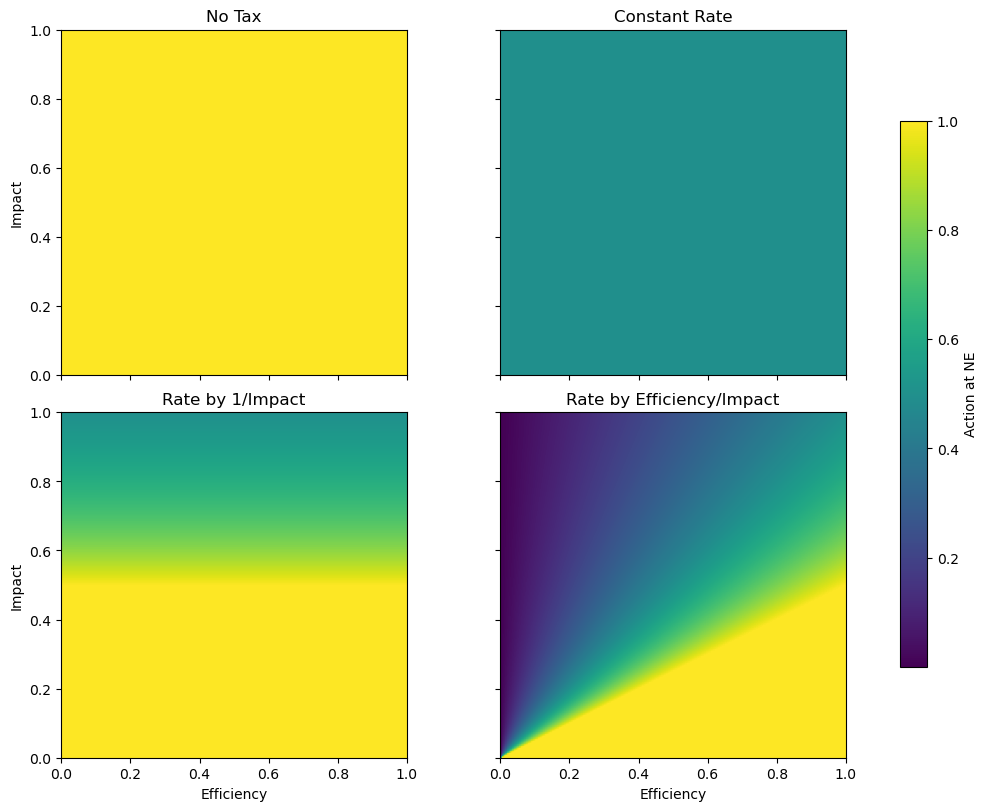

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Adjusted functions
def func1(x, y):
    return np.ones_like(x)

def func2(x, y):
    return 0.5 * np.ones_like(x)

def func3(x, y):
    return np.minimum(1, 0.5 / y)

def func4(x, y):
    return np.minimum(1, 0.5 * x / y)

# Create a grid of values for x and y in the range [0, 1]
x = np.linspace(0.001, 1, 200)  # Avoid division by zero in func3 and func4
y = np.linspace(0.001, 1, 200)
X, Y = np.meshgrid(x, y)

# Calculate vmin and vmax across all functions
vmin = min(func1(X, Y).min(), func2(X, Y).min(), func3(X, Y).min(), func4(X, Y).min())
vmax = max(func1(X, Y).max(), func2(X, Y).max(), func3(X, Y).max(), func4(X, Y).max())

# Create a 2x2 subplot with shared x-axis, y-axis, and colorbar
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True, constrained_layout=True)

# Plot the heatmaps for each adjusted function using imshow
heatmap1 = axs[0, 0].imshow(func1(X, Y), cmap='viridis', extent=[0, 1, 0, 1], origin='lower', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('No Tax')

heatmap2 = axs[0, 1].imshow(func2(X, Y), cmap='viridis', extent=[0, 1, 0, 1], origin='lower', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Constant Rate')

heatmap3 = axs[1, 0].imshow(func3(X, Y), cmap='viridis', extent=[0, 1, 0, 1], origin='lower', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Rate by 1/Impact')

heatmap4 = axs[1, 1].imshow(func4(X, Y), cmap='viridis', extent=[0, 1, 0, 1], origin='lower', vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Rate by Efficiency/Impact')

axs[1,0].set_xlabel('Efficiency')
axs[1,1].set_xlabel('Efficiency')
axs[0,0].set_ylabel('Impact')
axs[1,0].set_ylabel('Impact')

# Add colorbars and adjust layout
cbar = fig.colorbar(heatmap4, ax=axs, shrink=0.75, pad=0.05)
cbar.set_label('Action at NE')

# Show the plot# Show the plot
plt.savefig('Taxtest.png',bbox_inches ='tight',dpi=600)
plt.show()